# import library

In [207]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
import json
import numpy as np
import ssl
import re
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

# Web scrape Bangkok District data from Wikipedia

In [255]:
ssl._create_default_https_context = ssl._create_unverified_context
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'
df = pd.read_html(url)[0]
df.head()

,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.66,100.40
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.77,100.65
2,Bang Khae,40,10160,บางแค,191781,4,13.70,100.41
3,Bang Khen,5,10220,บางเขน,189539,2,13.87,100.60
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.69,100.50


In [256]:
df_bangkok = df[["Thai","Latitude","Longitude"]]
df_bangkok.columns = ["Neighborhood","Latitude","Longitude"]
df_bangkok['Borough'] = "Bangkok"
df_bangkok.head()

/Users/rachataburin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Latitude,Longitude,Borough
0,บางบอน,13.66,100.40,Bangkok
1,บางกะปิ,13.77,100.65,Bangkok
2,บางแค,13.70,100.41,Bangkok
3,บางเขน,13.87,100.60,Bangkok
4,บางคอแหลม,13.69,100.50,Bangkok


In [257]:
bangkok_data = df_bangkok.copy()

In [258]:
bangkok_data.Neighborhood.dropna(inplace=True)
bangkok_data.shape

(50, 4)

# Get latitude, longitude of Bangkok

In [215]:
from geopy.geocoders import Nominatim
address = 'Bangkok'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok are {}, {}.'.format(latitude, longitude))

/Users/rachataburin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Bangkok are 13.7542529, 100.493087.


# Use folium to vitualize location data

In [265]:
import folium
map_bangkok= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district,city in zip(bangkok_data['Latitude'], bangkok_data['Longitude'],df['District(Khet)'],bangkok_data['Borough']):
    label = '{},{}'.format(district,city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangkok)  
    
map_bangkok

# Input Foursquare CLIENT 

In [408]:
CLIENT_ID = 'XXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXXX
CLIENT_SECRET:XXXXX


In [218]:
bangkok_data.reset_index(inplace= True)

In [219]:
bangkok_data.loc[0, 'Neighborhood']

'บางบอน'

# Foursquare API to get around venues in each Neighborhood
#### LIMIT is LIMIT OF VENUES IN EACH Neighborhood
#### Radius is LIMIT OF AREA TO SEARCH

In [220]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [222]:
bangkok_venues = getNearbyVenues(names=bangkok_data['Neighborhood'],
                                   latitudes=bangkok_data['Latitude'],
                                   longitudes=bangkok_data['Longitude']
                                  )

บางบอน
บางกะปิ
บางแค
บางเขน
บางคอแหลม
บางขุนเทียน
บางนา
บางพลัด
บางรัก
บางซื่อ
บางกอกน้อย
บางกอกใหญ่
บึงกุ่ม
จตุจักร
จอมทอง
ดินแดง
ดอนเมือง
ดุสิต
ห้วยขวาง
คันนายาว
คลองสามวา
คลองสาน
คลองเตย
หลักสี่
ลาดกระบัง
ลาดพร้าว
มีนบุรี
หนองจอก
หนองแขม
ปทุมวัน
ภาษีเจริญ
พญาไท
พระโขนง
พระนคร
ป้อมปราบศัตรูพ่าย
ประเวศ
ราษฏร์บูรณะ
ราชเทวี
สายไหม
สัมพันธวงศ์
สะพานสูง
สาทร
สวนหลวง
ตลิ่งชัน
ทวีวัฒนา
ธนบุรี
ทุ่งครุ
วังทองหลาง
วัฒนา
ยานนาวา


# Explore Data

In [223]:
print(bangkok_venues.shape)
bangkok_venues.head()

(2901, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,บางบอน,13.66,100.40,ขาหมูบางหว้า,13.66,100.40,Thai Restaurant
1,บางบอน,13.66,100.40,Irashaimase Japanese Restaurant,13.66,100.40,Japanese Restaurant
2,บางบอน,13.66,100.40,ร้านต้นไม้ ริมถนนกาญจนาภิเษก,13.65,100.41,Garden Center
3,บางบอน,13.66,100.40,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.65,100.41,Noodle House
4,บางบอน,13.66,100.40,ส.สุขโภชนา,13.66,100.40,Chinese Restaurant


In [224]:
bangkok_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,บางบอน,13.66,100.40,ขาหมูบางหว้า,13.66,100.40,Thai Restaurant
1,บางบอน,13.66,100.40,Irashaimase Japanese Restaurant,13.66,100.40,Japanese Restaurant
2,บางบอน,13.66,100.40,ร้านต้นไม้ ริมถนนกาญจนาภิเษก,13.65,100.41,Garden Center
3,บางบอน,13.66,100.40,เจ๊ไน้ ก๋วยเตี๋ยวเป็ดตุ๋น,13.65,100.41,Noodle House
4,บางบอน,13.66,100.40,ส.สุขโภชนา,13.66,100.40,Chinese Restaurant
5,บางบอน,13.66,100.40,Lotus Express (โลตัส เอ็กซ์เพรส),13.66,100.40,Convenience Store
6,บางบอน,13.66,100.40,ทิพวรรณโอชา ก๋วยเตี๋ยวเนื้อตุ๋น,13.65,100.41,Noodle House
7,บางบอน,13.66,100.40,Bussabar Steak House,13.66,100.40,Bar
8,บางบอน,13.66,100.40,7-Eleven (เซเว่น อีเลฟเว่น),13.66,100.39,Convenience Store
9,บางบอน,13.66,100.40,ลาบร้อยเอ็ด เสือเคหะ,13.66,100.40,Som Tum Restaurant


In [225]:
bangkok_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
คลองสาน,100,100,100,100,100,100
คลองสามวา,45,45,45,45,45,45
คลองเตย,27,27,27,27,27,27
คันนายาว,83,83,83,83,83,83
จตุจักร,90,90,90,90,90,90
จอมทอง,23,23,23,23,23,23
ดอนเมือง,23,23,23,23,23,23
ดินแดง,37,37,37,37,37,37
ดุสิต,62,62,62,62,62,62


In [226]:
print('There are {} uniques categories.'.format(len(bangkok_venues['Venue Category'].unique())))

There are 232 uniques categories.


In [227]:
# one hot encoding
bangkok_onehot = pd.get_dummies(bangkok_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangkok_onehot['Neighborhood'] = bangkok_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bangkok_onehot.columns[-1]] + list(bangkok_onehot.columns[:-1])
bangkok_onehot = bangkok_onehot[fixed_columns]

bangkok_onehot.head()

,Zoo Exhibit,Accessories Store,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Venue,Neighborhood,Night Market,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Gym,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Toll Booth,Toll Plaza,Tonkatsu Restaurant,Tour Provider,Track,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,บางบอน,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,บางบอน,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [228]:
bangkok_onehot.shape

(2901, 232)

In [229]:
bangkok_overall = bangkok_onehot.groupby('Neighborhood').sum().reset_index()
bangkok_overall

,Neighborhood,Zoo Exhibit,Accessories Store,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Venue,Night Market,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Gym,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Toll Booth,Toll Plaza,Tonkatsu Restaurant,Tour Provider,Track,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,คลองสาน,0,0,0,0,0,4,0,0,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,4,0,1,7,0,2,1,7,0,0,0,0,0,0,0,0,0,2,7,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,3,4,1,0,2,1,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,1,1,0,0,2,1,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,คลองสามวา,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

# Popular Venue Category in Bangkok

In [230]:
pd.options.display.float_format = "{:.2f}".format
popular = bangkok_overall.sum().to_frame().reset_index().rename(columns={"index":"category",0:"amount"}).iloc[1:].sort_values(by="amount",ascending= False)
popular['percent'] = popular.amount*100 / popular.amount.sum()
popular['percent'] = popular['percent'].apply(lambda x : str(round(x,2))+'%')
popular.set_index('category',inplace=True)

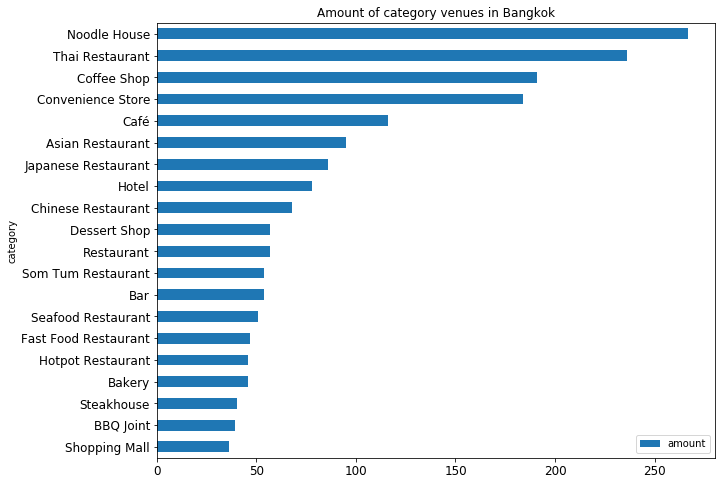

In [231]:
top20 = popular['amount'].iloc[0:20]
top20 = top20.to_frame().sort_values(by='amount')
top20.plot(kind='barh',figsize=(10,8))
plt.tick_params(labelsize=12)
plt.title('Amount of category venues in Bangkok')
plt.show()

In [270]:
bangkok_grouped = bangkok_onehot.groupby('Neighborhood').mean().reset_index()
bangkok_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Venue,Night Market,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Gym,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Toll Booth,Toll Plaza,Tonkatsu Restaurant,Tour Provider,Track,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wings Joint,Yoga Studio,Zoo
0,คลองสาน,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.01,0.07,0.00,0.02,0.01,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.07,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.03,0.04,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,

# Top 5 Categories

In [271]:
num_top_venues = 5

for hood in bangkok_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bangkok_grouped[bangkok_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----คลองสาน----
                venue  freq
0         Coffee Shop  0.07
1        Noodle House  0.07
2        Dessert Shop  0.07
3  Chinese Restaurant  0.07
4     Thai Restaurant  0.05


----คลองสามวา----
                 venue  freq
0           Restaurant  0.09
1              Exhibit  0.09
2      Thai Restaurant  0.09
3  Japanese Restaurant  0.07
4         Noodle House  0.07


----คลองเตย----
               venue  freq
0  Convenience Store  0.19
1        Coffee Shop  0.15
2         Food Truck  0.07
3        Karaoke Bar  0.04
4             Bakery  0.04


----คันนายาว----
                 venue  freq
0      Thai Restaurant  0.08
1  Japanese Restaurant  0.07
2          Coffee Shop  0.06
3         Noodle House  0.05
4               Bakery  0.05


----จตุจักร----
                  venue  freq
0           Coffee Shop  0.12
1       Thai Restaurant  0.10
2          Noodle House  0.06
3  Fast Food Restaurant  0.06
4   Japanese Restaurant  0.04


----จอมทอง----
               venue  freq
0    Th

In [272]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [273]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangkok_grouped['Neighborhood']

for ind in np.arange(bangkok_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangkok_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,คลองสาน,Coffee Shop,Dessert Shop,Noodle House,Chinese Restaurant,Thai Restaurant,Art Gallery,Hotel Bar,Café,Restaurant,Hotel
1,คลองสามวา,Exhibit,Restaurant,Thai Restaurant,Japanese Restaurant,Noodle House,Pub,Grocery Store,Zoo,Dessert Shop,Coffee Shop
2,คลองเตย,Convenience Store,Coffee Shop,Food Truck,Recording Studio,Bar,Residential Building (Apartment / Condo),Noodle House,Chinese Restaurant,Canal,Shopping Mall
3,คันนายาว,Thai Restaurant,Japanese Restaurant,Coffee Shop,Bakery,Som Tum Restaurant,Noodle House,Clothing Store,Pizza Place,Ice Cream Shop,Shopping Mall
4,จตุจักร,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Noodle House,Japanese Restaurant,Flea Market,Gym / Fitness Center,Convenience Store,Café,Shabu-Shabu Restaurant


In [409]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,คลองสาน,Coffee Shop,Dessert Shop,Noodle House,Chinese Restaurant,Thai Restaurant,Art Gallery,Hotel Bar,Café,Restaurant,Hotel
1,2,คลองสามวา,Exhibit,Restaurant,Thai Restaurant,Japanese Restaurant,Noodle House,Pub,Grocery Store,Zoo,Dessert Shop,Coffee Shop
2,1,คลองเตย,Convenience Store,Coffee Shop,Food Truck,Recording Studio,Bar,Residential Building (Apartment / Condo),Noodle House,Chinese Restaurant,Canal,Shopping Mall
3,2,คันนายาว,Thai Restaurant,Japanese Restaurant,Coffee Shop,Bakery,Som Tum Restaurant,Noodle House,Clothing Store,Pizza Place,Ice Cream Shop,Shopping Mall
4,2,จตุจักร,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Noodle House,Japanese Restaurant,Flea Market,Gym / Fitness Center,Convenience Store,Café,Shabu-Shabu Restaurant
5,1,จอมทอง,Thai Restaurant,Convenience Store,Coffee Shop,Asian Restaurant,Pet Store,Plaza,Flea Market,Electronics Store,Restaurant,Food Truck
6,1,ดอนเมือง,Thai Restaurant,Convenience Store,Hotel,Airport Service,Restaurant,Food Truck,Coffee Shop,Sushi Restaurant,Flea Market,Chinese Restaurant
7,1,ดินแดง,Convenience Store,Noodle House,Thai Restaurant,Sports Club,Dessert Shop,Gym / Fitness Center,Satay Restaurant,Market,Flea Market,Sporting Goods Shop
8,3,ดุสิต,Noodle House,Thai Restaurant,Convenience Store,Asian Restaurant,Café,Som Tum Restaurant,Coffee Shop,Palace,Bar,Chinese Restaurant
9,1,ตลิ่งชัน,Convenience Store,Noodle House,Coffee Shop,Thai Restaurant,Seafood Restaurant,Restaurant,Bakery,Badminton Court,Chinese Restaurant,Asian Restaurant


# Find optimize K by Elbow method

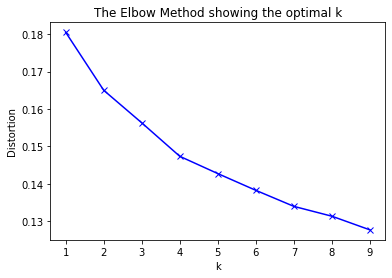

In [275]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
bangkok_grouped_clustering = bangkok_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(bangkok_grouped_clustering)
    distortions.append(sum(np.min(cdist(bangkok_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bangkok_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Clusterin by K-mean

In [276]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangkok_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 2, 1, 1, 1, 3, 1], dtype=int32)

In [277]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangkok_merged = bangkok_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangkok_merged = bangkok_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bangkok_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,บางบอน,13.66,100.40,Bangkok,1,Noodle House,Coffee Shop,Convenience Store,Thai Restaurant,Garden Center,Spa,Fast Food Restaurant,Gas Station,Café,Chinese Restaurant
1,บางกะปิ,13.77,100.65,Bangkok,2,Coffee Shop,Japanese Restaurant,Som Tum Restaurant,Noodle House,Thai Restaurant,Steakhouse,Clothing Store,Fast Food Restaurant,BBQ Joint,Ramen Restaurant
2,บางแค,13.70,100.41,Bangkok,3,Convenience Store,Noodle House,Japanese Restaurant,Shopping Mall,Flea Market,Track,Shop & Service,Food Truck,Miscellaneous Shop,Thai Restaurant
3,บางเขน,13.87,100.60,Bangkok,2,Convenience Store,Coffee Shop,Fast Food Restaurant,Noodle House,Hotpot Restaurant,Asian Restaurant,Bookstore,Steakhouse,Vietnamese Restaurant,Ice Cream Shop
4,บางคอแหลม,13.69,100.50,Bangkok,1,Thai Restaurant,Coffee Shop,Noodle House,Convenience Store,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Pub,Som Tum Restaurant,Bus Stop


In [278]:
df.rename(columns={"Thai":"Neighborhood"},inplace=True)
join_df = pd.merge(bangkok_merged,df[["Neighborhood","District(Khet)"]],on='Neighborhood',how='left')
join_df.head()

,Neighborhood,Latitude,Longitude,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District(Khet)
0,บางบอน,13.66,100.40,Bangkok,1,Noodle House,Coffee Shop,Convenience Store,Thai Restaurant,Garden Center,Spa,Fast Food Restaurant,Gas Station,Café,Chinese Restaurant,Bang Bon
1,บางกะปิ,13.77,100.65,Bangkok,2,Coffee Shop,Japanese Restaurant,Som Tum Restaurant,Noodle House,Thai Restaurant,Steakhouse,Clothing Store,Fast Food Restaurant,BBQ Joint,Ramen Restaurant,Bang Kapi
2,บางแค,13.70,100.41,Bangkok,3,Convenience Store,Noodle House,Japanese Restaurant,Shopping Mall,Flea Market,Track,Shop & Service,Food Truck,Miscellaneous Shop,Thai Restaurant,Bang Khae
3,บางเขน,13.87,100.60,Bangkok,2,Convenience Store,Coffee Shop,Fast Food Restaurant,Noodle House,Hotpot Restaurant,Asian Restaurant,Bookstore,Steakhouse,Vietnamese Restaurant,Ice Cream Shop,Bang Khen
4,บางคอแหลม,13.69,100.50,Bangkok,1,Thai Restaurant,Coffee Shop,Noodle House,Convenience Store,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Pub,Som Tum Restaurant,Bus Stop,Bang Kho Laem


In [284]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11,tiles='OpenStreetMap')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,top in zip(bangkok_merged['Latitude'], bangkok_merged['Longitude'], join_df['District(Khet)'], bangkok_merged['Cluster Labels'],bangkok_merged['1st Most Common Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Top1: ' +str(top), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Explore Each Clusters

#### Cluster 0 : Intersection

In [410]:
clus1 = bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 0, bangkok_merged.columns[[0] + list(range(5, bangkok_merged.shape[1]))]]
clus1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,มีนบุรี,Intersection,Restaurant,Bus Station,Thai Restaurant,Massage Studio,Coffee Shop,Duty-free Shop,Donut Shop,Garden,Gaming Cafe


#### Cluster 1 : Convenience Store

In [242]:
clus2 = bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 1, bangkok_merged.columns[[1] + list(range(5, bangkok_merged.shape[1]))]]
clus2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,บางบอน,1,Noodle House,Coffee Shop,Convenience Store,Thai Restaurant,Garden Center,Spa,Fast Food Restaurant,Gas Station,Café,Chinese Restaurant
4,บางคอแหลม,1,Thai Restaurant,Coffee Shop,Noodle House,Convenience Store,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Pub,Som Tum Restaurant,Bus Stop
7,บางพลัด,1,Convenience Store,Café,Fast Food Restaurant,Thai Restaurant,Seafood Restaurant,Coffee Shop,Flea Market,Restaurant,Cocktail Bar,Other Repair Shop
12,บึงกุ่ม,1,Coffee Shop,Café,Convenience Store,Supermarket,Bakery,Park,Flea Market,Food Truck,Noodle House,Thai Restaurant
14,จอมทอง,1,Thai Restaurant,Convenience Store,Coffee Shop,Asian Restaurant,Pet Store,Plaza,Flea Market,Electronics Store,Restaurant,Food Truck
15,ดินแดง,1,Convenience Store,Noodle House,Thai Restaurant,Sports Club,Dessert Shop,Gym / Fitness Center,Satay Restaurant,Market,Flea Market,Sporting Goods Shop
16,ดอนเมือง,1,Thai Restaurant,Convenience Store,Hotel,Airport Service,Restaurant,Food Truck,Coffee Shop,Sushi Restaurant,Flea Market,Chinese Restaurant
18,ห้วยขวาง,1,Thai Restaurant,Noodle House,Convenience Store,Japanese Restaurant,Dessert Shop,Hotel,Som Tum Restaurant,BBQ Joint,Chinese Restaurant,Seafood Restaurant
22,คลองเตย,1,Convenience Store,Coffee Shop,Food Truck,Recording Studio,Bar,Residential Building (Apartment / Condo),Noodle House,Chinese Restaurant,Canal,Shopping Mall
23,หลักสี่,1,Thai Restaurant,Coffee Shop,Convenience Store,Fast Food Restaurant,Food Court,Dumpling Restaurant,Japanese Restaurant,Steakhouse,Bar,Canal


#### Cluster 2 : Coffee Shop

In [243]:
clus3=bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 2, bangkok_merged.columns[[1] + list(range(5, bangkok_merged.shape[1]))]]
clus3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,บางกะปิ,2,Coffee Shop,Japanese Restaurant,Som Tum Restaurant,Noodle House,Thai Restaurant,Steakhouse,Clothing Store,Fast Food Restaurant,BBQ Joint,Ramen Restaurant
3,บางเขน,2,Convenience Store,Coffee Shop,Fast Food Restaurant,Noodle House,Hotpot Restaurant,Asian Restaurant,Bookstore,Steakhouse,Vietnamese Restaurant,Ice Cream Shop
5,บางขุนเทียน,2,Thai Restaurant,Japanese Restaurant,Coffee Shop,Café,Steakhouse,Hotpot Restaurant,Pizza Place,Dessert Shop,Bakery,Som Tum Restaurant
8,บางรัก,2,Noodle House,Thai Restaurant,Chinese Restaurant,Hotel,Café,Seafood Restaurant,Coffee Shop,Japanese Restaurant,Hostel,Shopping Mall
13,จตุจักร,2,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Noodle House,Japanese Restaurant,Flea Market,Gym / Fitness Center,Convenience Store,Café,Shabu-Shabu Restaurant
19,คันนายาว,2,Thai Restaurant,Japanese Restaurant,Coffee Shop,Bakery,Som Tum Restaurant,Noodle House,Clothing Store,Pizza Place,Ice Cream Shop,Shopping Mall
20,คลองสามวา,2,Exhibit,Restaurant,Thai Restaurant,Japanese Restaurant,Noodle House,Pub,Grocery Store,Zoo,Dessert Shop,Coffee Shop
21,คลองสาน,2,Coffee Shop,Dessert Shop,Noodle House,Chinese Restaurant,Thai Restaurant,Art Gallery,Hotel Bar,Café,Restaurant,Hotel
25,ลาดพร้าว,2,Noodle House,Coffee Shop,Convenience Store,Thai Restaurant,Café,BBQ Joint,Restaurant,Asian Restaurant,Som Tum Restaurant,Bookstore
29,ปทุมวัน,2,Noodle House,Asian Restaurant,Chinese Restaurant,Hostel,Hotel,Dessert Shop,Thai Restaurant,Seafood Restaurant,Coffee Shop,BBQ Joint


#### Cluster 3 : Noodle House

In [244]:
clus4 =bangkok_merged.loc[bangkok_merged['Cluster Labels'] == 3, bangkok_merged.columns[[1] + list(range(5, bangkok_merged.shape[1]))]]
clus4

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,บางแค,3,Convenience Store,Noodle House,Japanese Restaurant,Shopping Mall,Flea Market,Track,Shop & Service,Food Truck,Miscellaneous Shop,Thai Restaurant
6,บางนา,3,Noodle House,Café,Asian Restaurant,Coffee Shop,Thai Restaurant,Pier,Supermarket,Convenience Store,Electronics Store,Seafood Restaurant
9,บางซื่อ,3,Noodle House,Thai Restaurant,Convenience Store,Train Station,Ice Cream Shop,Asian Restaurant,Coffee Shop,Fast Food Restaurant,Hotpot Restaurant,Restaurant
10,บางกอกน้อย,3,Noodle House,Convenience Store,Som Tum Restaurant,Asian Restaurant,Thai Restaurant,Coffee Shop,Chinese Restaurant,Steakhouse,Park,Mobile Phone Shop
11,บางกอกใหญ่,3,Noodle House,Asian Restaurant,Convenience Store,Train Station,Seafood Restaurant,Coffee Shop,Farmers Market,Dessert Shop,Gym,Restaurant
17,ดุสิต,3,Noodle House,Thai Restaurant,Convenience Store,Asian Restaurant,Café,Som Tum Restaurant,Coffee Shop,Palace,Bar,Chinese Restaurant
35,ประเวศ,3,Noodle House,Convenience Store,Soccer Field,Toll Booth,Coffee Shop,Gym / Fitness Center,Outdoor Gym,Halal Restaurant,Pet Store,Electronics Store
41,สาทร,3,Noodle House,Asian Restaurant,Convenience Store,Chinese Restaurant,Thai Restaurant,Dessert Shop,Bar,Hotel,Park,Café
42,สวนหลวง,3,Noodle House,Coffee Shop,Thai Restaurant,Asian Restaurant,Convenience Store,Som Tum Restaurant,Massage Studio,Café,Shopping Mall,Food Truck
44,ทวีวัฒนา,3,Coffee Shop,Noodle House,Convenience Store,Asian Restaurant,Music Venue,Bakery,Clothing Store,Chinese Restaurant,Flea Market,Diner


In [300]:
cluster_venue = pd.merge(bangkok_overall,bangkok_merged[['Neighborhood',"Cluster Labels"]],on='Neighborhood',how='left')
group_cluster  = cluster_venue.groupby('Cluster Labels').sum()
group_cluster

,Zoo Exhibit,Accessories Store,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,Comic Shop,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Floating Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Driving Range,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Leather Goods Store,Library,Light Rail Station,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Venue,Night Market,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Gym,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pet Café,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Toll Booth,Toll Plaza,Tonkatsu Restaurant,Tour Provider,Track,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wings Joint,Yoga Studio,Zoo
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,3,1,1,2,0,1,23,1,2,7,2,15,12,2,1,1,3,0,1,0,0,1,2,1,0,2,0,0,2,0,1,1,4,1,31,2,0,20,0,0,2,48,0,0,0,94,0,0,0,0,

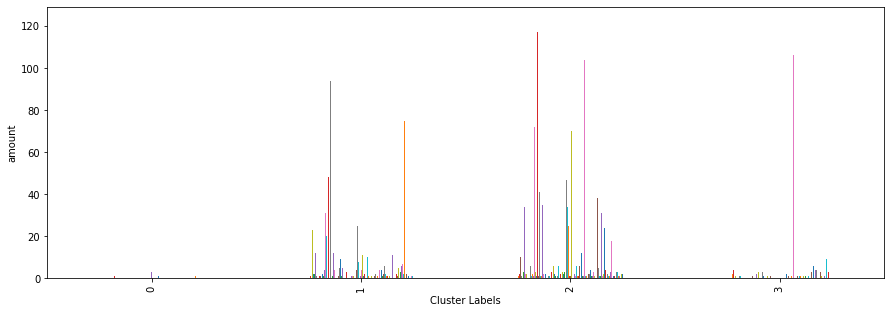

In [320]:
group_cluster.plot(kind='bar',figsize=(15,5),legend=None)
plt.ylabel('amount')
plt.show()

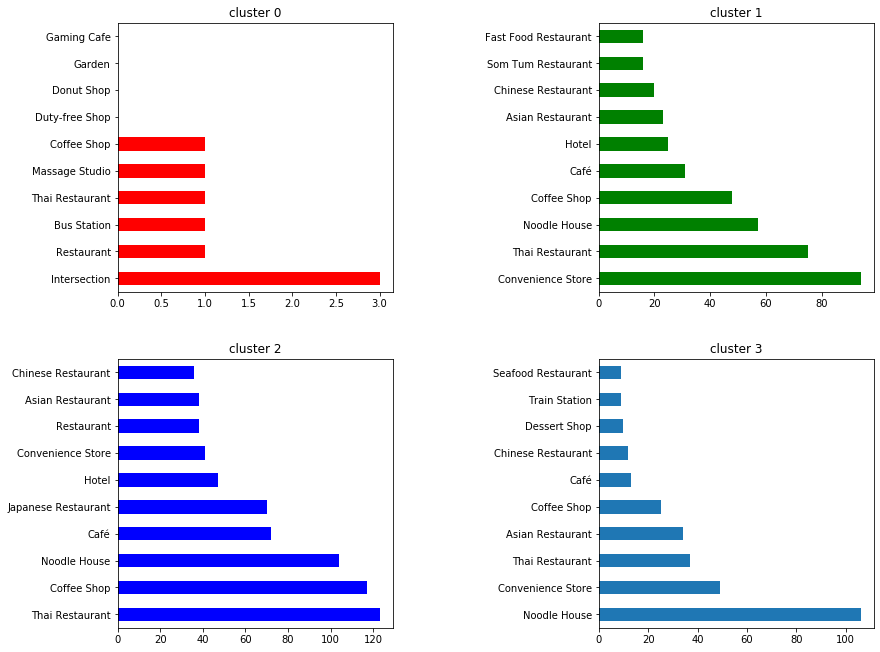

In [364]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
group_cluster.loc[0,:].sort_values(ascending=False).to_frame()[0:10].plot(kind='barh',ax = axs[0,0],color='red',title='cluster 0',legend=None)
group_cluster.loc[1,:].sort_values(ascending=False).to_frame()[0:10].plot(kind='barh',ax = axs[0,1],color='green',title='cluster 1',legend=None)
group_cluster.loc[2,:].sort_values(ascending=False).to_frame()[0:10].plot(kind='barh',ax = axs[1,0],color='blue',title='cluster 2',legend=None)
group_cluster.loc[3,:].sort_values(ascending=False).to_frame()[0:10].plot(kind='barh',ax = axs[1,1],title='cluster 3',legend=None)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.8, hspace=0.25, wspace=0.75)

In [365]:
group_cluster.loc[0,:].sort_values(ascending=False).to_frame()[0:10]

,0
Intersection,3
Restaurant,1
Bus Station,1
Thai Restaurant,1
Massage Studio,1
Coffee Shop,1
Duty-free Shop,0
Donut Shop,0
Garden,0
Gaming Cafe,0


In [309]:
group_cluster.loc[1,:].sort_values(ascending=False).to_frame()[0:10]

,1
Convenience Store,94
Thai Restaurant,75
Noodle House,57
Coffee Shop,48
Café,31
Hotel,25
Asian Restaurant,23
Chinese Restaurant,20
Som Tum Restaurant,16
Fast Food Restaurant,16


In [310]:
group_cluster.loc[2,:].sort_values(ascending=False).to_frame()[0:10]

,2
Thai Restaurant,123
Coffee Shop,117
Noodle House,104
Café,72
Japanese Restaurant,70
Hotel,47
Convenience Store,41
Restaurant,38
Asian Restaurant,38
Chinese Restaurant,36


In [314]:
group_cluster.loc[3,:].sort_values(ascending=False).to_frame()[0:10]

,3
Noodle House,106
Convenience Store,49
Thai Restaurant,37
Asian Restaurant,34
Coffee Shop,25
Café,13
Chinese Restaurant,12
Dessert Shop,10
Train Station,9
Seafood Restaurant,9


# Additional

## Living Population in Bangkok District data from stat.bora.dopa.go.th

In [395]:
data_people = pd.read_excel('pop_stat_2563.xlsx',encoding='utf-8')
data_people.head()

,เขต,ชาย,หญิง,รวม,บ้าน
0,ท้องถิ่นเขตพระนคร,23080,24621,47701,19155
1,ท้องถิ่นเขตดุสิต,48615,41154,89769,31955
2,ท้องถิ่นเขตหนองจอก,85682,90340,176022,65048
3,ท้องถิ่นเขตบางรัก,22834,25393,48227,32347
4,ท้องถิ่นเขตบางเขน,89273,99727,189000,112614


In [396]:
data_people.columns = ["Neighborhood","Male","Female","Total","House"]
data_people.Neighborhood = data_people.Neighborhood.apply(lambda x : re.sub("ท้องถิ่นเขต","",x))
data_people.Neighborhood.replace("ราษฎร์บูรณะ","ราษฏร์บูรณะ",inplace=True)
data_people.head()

,Neighborhood,Male,Female,Total,House
0,พระนคร,23080,24621,47701,19155
1,ดุสิต,48615,41154,89769,31955
2,หนองจอก,85682,90340,176022,65048
3,บางรัก,22834,25393,48227,32347
4,บางเขน,89273,99727,189000,112614


In [397]:
data_people.shape

(50, 5)

In [398]:
pop_cluster = pd.merge(bangkok_merged[['Neighborhood','Cluster Labels']],data_people,on='Neighborhood',how='left')
pop_cluster

,Neighborhood,Cluster Labels,Male,Female,Total,House
0,บางบอน,1,50628,55056,105684,50531
1,บางกะปิ,2,66559,79549,146108,104926
2,บางแค,3,90085,103406,193491,92959
3,บางเขน,2,89273,99727,189000,112614
4,บางคอแหลม,1,41260,45638,86898,39544
5,บางขุนเทียน,2,87656,98168,185824,90017
6,บางนา,3,42021,48104,90125,70410
7,บางพลัด,1,41565,49304,90869,55029
8,บางรัก,2,22834,25393,48227,32347
9,บางซื่อ,3,59086,67224,126310,75635


In [406]:
group_pop = pop_cluster.groupby("Cluster Labels").sum()
group_pop

,Male,Female,Total,House
Cluster Labels,,,,
0,67340,75246,142586,61051
1,1053942,1177627,2231569,1145942
2,960736,1090607,2051343,1179473
3,587298,653468,1240766,654649


In [407]:
group_pop.Male = group_pop.Male /group_pop.Total
group_pop.Female = group_pop.Female / group_pop.Total
group_pop.House = group_pop.House/group_pop.Total
group_pop

,Male,Female,Total,House
Cluster Labels,,,,
0,0.47,0.53,142586,0.43
1,0.47,0.53,2231569,0.51
2,0.47,0.53,2051343,0.57
3,0.47,0.53,1240766,0.53


# Solution

From our data, I know top venue categories and district clusters area in Bangkok after that I want to know, if I'm a new contractor is trying to start my own business, Which venue categories and district clusters area should I open? 

I have many ways to decide which venue category I should open.

## For about Category

If I have no choise in mind, 

* I can start with top category like Noodle House,Thai Restaurant,Coffee Shop or 
Convenience Store. On the other hand, 
* I can start with non-popular category like Hainan Restaurant,Gaming Cafe or
Organic Grocery.

## For about District

If I decide to open Noodle house,I have many way to decide too.
* I can open at cluster labels number 3 which has the most amount of Noodle house venues in Bangkok.

* I can open at some district in other cluster which hasn't many Noodle house venue like สายไหม	,บางพลัด or มีนบุรี.

* I can open at some district which my venue have influence.Example, I know in cluster 2 most popular categories are cafe and coffee shop so I can open import coffee beans shop in this cluster.

## For about Population
* In every clusters in Bangkok have female more than male around 6%, so It will be useful for female's product.

my analysis is not predictive or regression model but use to support in decision.